Refer to the [Wikipedia article](https://en.wikipedia.org/wiki/Self-avoiding_walk) on self-avoiding walks for a good primer on the subject. [Bauerschmidt et al. (2012)](https://www.ihes.fr/~duminil/publi/saw_lecture_notes.pdf) give an extremely thorough description of known qualities of self-avoiding random walks and their connections to other areas of mathematics. Here are links to some other resources I found informative:
 - https://mathoverflow.net/questions/158811/wander-distance-of-self-avoiding-walk-that-backs-out-of-culs-de-sac
 - https://mathoverflow.net/questions/52813/self-avoiding-walk-enumerations
 - https://mathoverflow.net/questions/41543/how-to-characterize-a-self-avoiding-
 - https://mathoverflow.net/questions/54144/self-avoiding-walk-pair-correlation
 - https://mathoverflow.net/questions/23583/self-avoidance-time-of-random-walk
 - https://mathoverflow.net/questions/181340/square-filling-self-avoiding-walk
 
Some exhaustive results by numerical simulation are available here:
 - https://secure.math.ubc.ca/~slade/lacecounts/index.html
 - https://secure.math.ubc.ca/~slade/se_tables.pdf
 
Here are some other academic results on the topic:
 - https://secure.math.ubc.ca/~slade/se_tables.pdf
 - https://www.sciencedirect.com/science/article/abs/pii/0032386185900084?via%3Dihub
 - https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.2993
 - https://arxiv.org/abs/1408.6714
 
Other interesting simulations/related information:
 - https://mathoverflow.net/questions/88659/traversing-the-infinite-square-grid
 - https://mathoverflow.net/questions/306794/counting-hamiltonian-cycles-in-n-times-n-square-grid
 - https://iopscience.iop.org/article/10.1088/0305-4470/38/42/001
 - https://mathoverflow.net/questions/67192/exactly-simulating-a-random-walk-from-infinity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import itertools
import random

In [2]:
dimensions = 2
D = dimensions
z = 10

start = [0, 0]
choices = []

for n in range(dimensions):
    for y in [-1, 1]:
        delta = np.zeros(dimensions).astype(np.int)
        delta[n] = y
        choices.append(delta)
choices = np.stack(choices)

print(choices)

[[-1  0]
 [ 1  0]
 [ 0 -1]
 [ 0  1]]


In [3]:
steps = []
@nb.njit
def valid_moves(g, m, q):
#     filtered = list(filter(lambda c: (0<=pos+c).all() and (pos+c<z).all() and grid[tuple(pos+c)] == 0, m))
    filtered = []
    for i in m:
#         print(pos, m)
        p = q+i
#         if (0<=p).all() and (p<z).all() and g[p[0], p[1]] == 0:
        if (0<=p).all():
            if (p<z).all():
                if g[p[0], p[1]] == 0:
#                     print(p, g[p[0], p[1]], (p<z).all(), z)
                    filtered.append(i)
    return filtered

In [4]:
@nb.jit(nopython=True)
def bound(x, a, b):
    if x >= b:
        x = b-1
    elif x < a:
        x = a
    return x

@nb.njit
def clip(x, a, b):
    for i in range(x.shape[0]):
        x[i] = bound(x[i], a, b)
    return x

In [9]:
#@nb.njit#(parallel=True)
def simulate(z, m=1, backtrack=True):
    for x in range(1):
        pos = np.array([0, 0])
#         grid = np.zeros([z] * D)
        grid = np.zeros((z, z), dtype=np.int64)
#         walks = []
#         steps = []
#         steps.append(pos)

#         steps = np.zeros((z**2, 2))
#         steps[0] = pos
        level = 0
#         TODO: randomize initial branches
        branches = np.zeros((z**2,), dtype=np.int64)
        
#         Loop through (n^2)*m steps, where n is the width of the grid and m is a coefficient
        for t in range(z**2*m):
    #         print(0<pos+delta[0]<z)
    #         print(grid[tuple(pos+delta[0])])
            possible = valid_moves(grid, choices, pos)
#             print(possible)
            grid[pos[0], pos[1]] = level+(z**2//4)
            
            if len(possible) > 0 and branches[level] < len(possible):
#                 delta = random.choice(possible)
#                 delta = np.random.choice(possible)
#                 np.random.shuffle(possible)
#                 index = np.random.randint(0, len(possible))
#                 branches[level] = index
#                 delta = possible[index]
                delta = possible[branches[level]]

#                 steps.append(delta)
                pos += delta
#                 steps.append(delta)
#                 steps[l] = delta

#                 pos = np.clip(pos, 0, z-1)
                
                pos = clip(pos, 0, z)
                
#                 grid[tuple(pos)] = 1
#                 print(pos[0])

#                 Move to the next "level" below the current one
#                 Only increase the step count if there are still spaces to move to
                if np.count_nonzero(grid) <= z**2-1 and level < z**2-1:
                    level += 1
                    branches[level] = 0
            else:
#                 lengths.append(t)
#                 walks.append(grid)
                if backtrack:
                    # TODO: prevent reselection of "stuck" path
            
#                     Reset value of current position and checked sub-branch
                    grid[pos[0], pos[1]] = 0
                    branches[level] = 0
                    
                    pos -= delta
                    pos = clip(pos, 0, z)
#                     steps.pop()
                    level -= 1
                    branches[level] += 1
                else:
                    break
                
#                 End simulation early if a "perfect" path which covers the entire grid is found
                if np.count_nonzero(grid) >= z**2-1:
                    break
#         else:
#         walks.append(grid)
    return grid

(-0.5, 4.5, 4.5, -0.5)

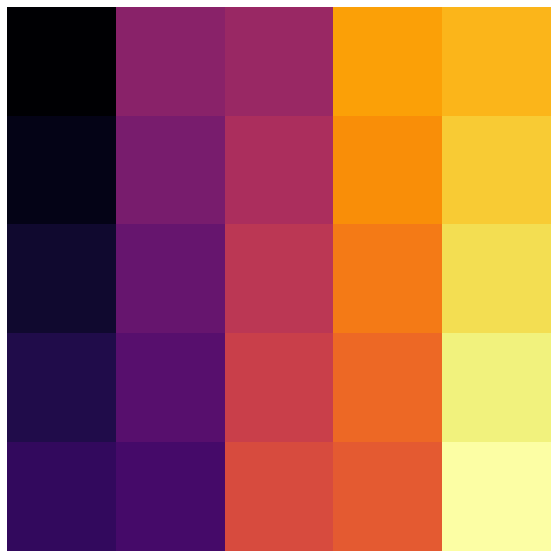

In [18]:
# Store the best discovered path (i.e., the one that covers the most cells in the grid)
best = None
# Track walks/paths and their lengths
lengths = []
walks = []
# Run multiple simulations
for i in range(300):
    G = simulate(5, 3, True)
#     if best:
#         print(best.max())
#     lengths.append(G.max())
    L = np.count_nonzero(G)
    lengths.append(L)
    walks.append(G)
    
#     If current path is longer than the best one found, store it instead
#     if best is None or G.max() > best.max():
    if best is None or np.count_nonzero(G) >= np.count_nonzero(best):
        best = G

# Display a visualization of the generated path
plt.figure(figsize=(10, 10))
plt.imshow(best, cmap='inferno')
plt.axis('off')

# decision trees? + parity
# random walks that close to a polygon
# (self-avoiding) random walks around obstructions
# add heuristics
# avoid and/or break at 
# add backtracking
# add step labels

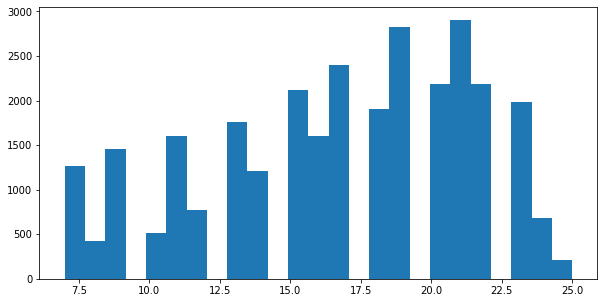

In [262]:
# Plot a histogram of the path lengths
plt.figure(figsize=(10, 5))
x = plt.hist(lengths, bins=25)

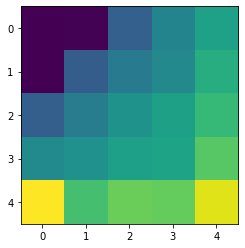

In [256]:
# Display the "average path", the mean of all those simulated
plt.imshow(np.average(np.stack(walks), axis=0))